In [20]:
import pandas as pd
from datetime import datetime
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [21]:
df = pd.read_csv(r'household_power_consumption.txt',delimiter=';')
df = df[:200000]
df.head()

C:\Users\91882\AppData\Local\Temp\ipykernel_20160\2653705138.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'household_power_consumption.txt',delimiter=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [22]:
df['date_time'] = df['Date'] + ' ' + df['Time']
date_format = '%d/%m/%Y %H:%M:%S'

In [23]:
def to_timestamp(time:str):
    return datetime.strptime(time,date_format).timestamp()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   200000 non-null  object 
 1   Time                   200000 non-null  object 
 2   Global_active_power    200000 non-null  object 
 3   Global_reactive_power  200000 non-null  object 
 4   Voltage                200000 non-null  object 
 5   Global_intensity       200000 non-null  object 
 6   Sub_metering_1         200000 non-null  object 
 7   Sub_metering_2         200000 non-null  object 
 8   Sub_metering_3         196268 non-null  float64
 9   date_time              200000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 15.3+ MB


In [25]:
df['date_time'] =df['date_time'].apply(to_timestamp)

In [26]:
df.sort_values(['date_time'],inplace = True)

In [27]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,1.166270e+09
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,1.166270e+09
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,1.166270e+09
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,1.166270e+09
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,1.166270e+09


In [28]:
df.isnull().sum()

Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           3732
date_time                   0
dtype: int64

In [29]:
df['Sub_metering_1'] =  df['Sub_metering_1'].replace("?",0)
df['Sub_metering_1'] = df['Sub_metering_1'].astype(float)
df['Sub_metering_2'] =  df['Sub_metering_2'].replace("?",0)
df['Sub_metering_2'] = df['Sub_metering_2'].astype(float)

In [30]:
df['Sub_metering_3'].fillna(df['Sub_metering_3'].mean(),inplace=True)
df['Sub_metering_3'].unique()

C:\Users\91882\AppData\Local\Temp\ipykernel_20160\2830144025.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sub_metering_3'].fillna(df['Sub_metering_3'].mean(),inplace=True)


array([17.       , 16.       , 18.       ,  9.       ,  0.       ,
        5.       , 19.       , 10.       , 20.       ,  8.       ,
        4.       ,  2.       ,  3.       , 11.       , 13.       ,
        6.       , 15.       ,  6.4437351, 12.       ,  1.       ,
       14.       ,  7.       ])

In [31]:
df['reading'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']

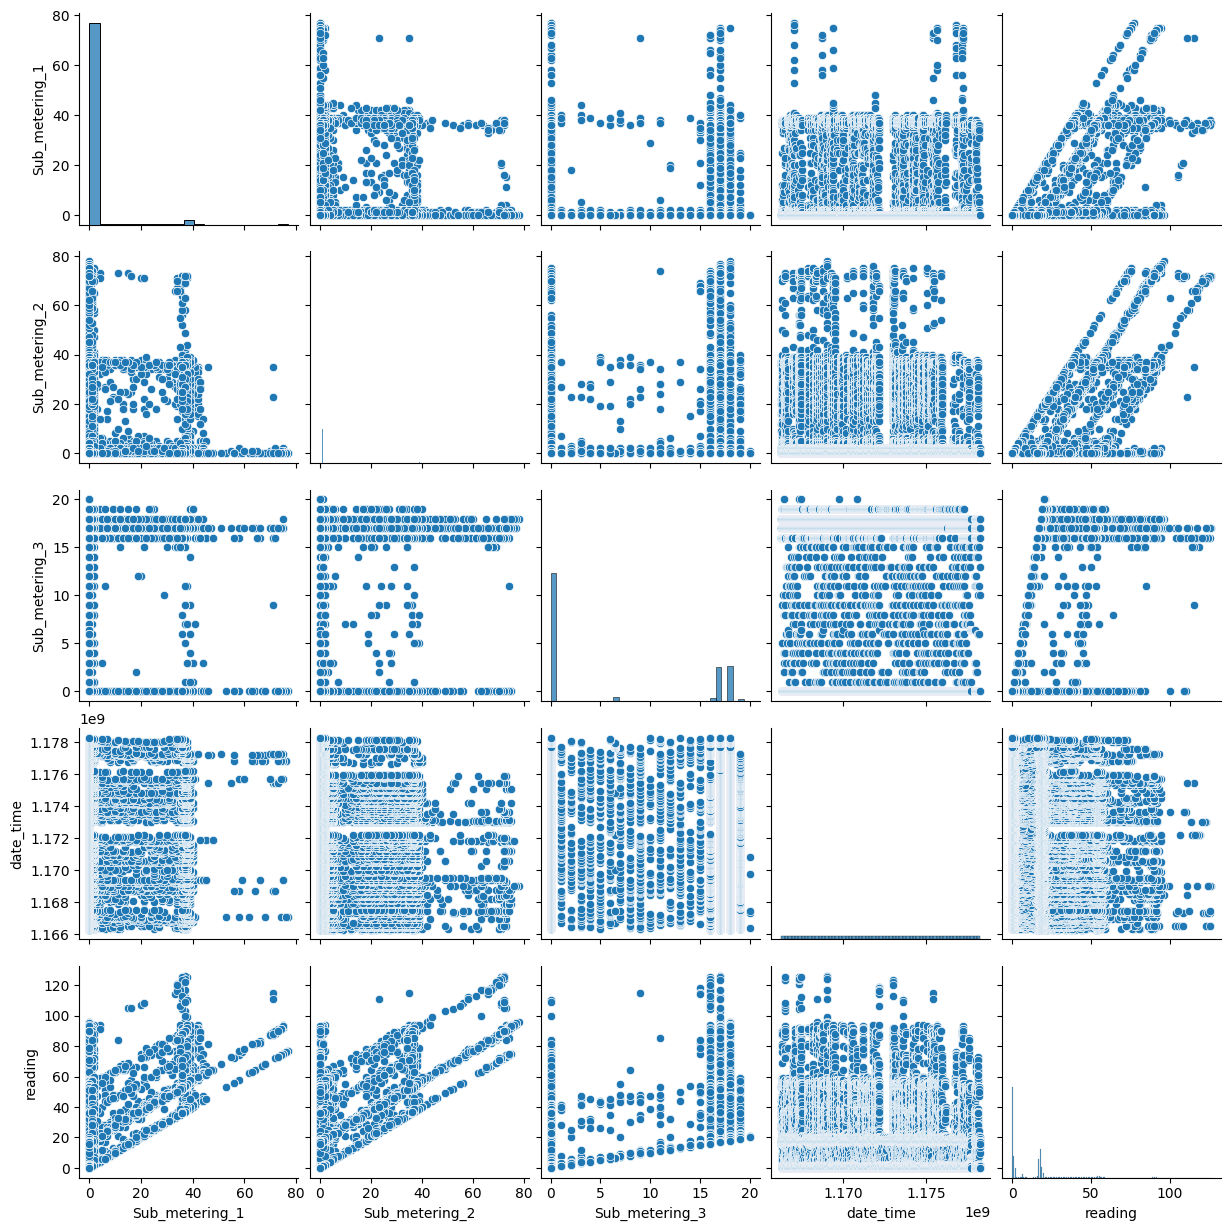

In [32]:
sb.pairplot(df)

In [33]:
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i : i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)
arr = np.arange(15)
sequence_length = 50 # Adjust as needed
x, y = create_sequences(arr, sequence_length)

In [34]:
x,y = create_sequences(df['reading'],sequence_length)

In [35]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\91882\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
model.fit(x, y, epochs=10, batch_size=64)

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 46.9623
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 66589659496448.0000
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 1289.9531
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 29025.0977
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 2550.6602
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 826.1060
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 840.4708
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 2339627.5000
Epoch 9/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 286.4939
Epoch 10/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 221.4655


In [39]:
pred = model.predict(x)

6249/6249 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step


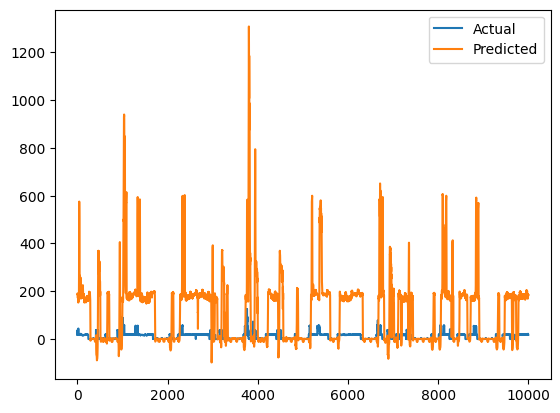

In [45]:
plt.plot(y[:10000], label='Actual')
plt.plot(pred[:10000], label='Predicted')
plt.legend()
plt.show()